## libraries

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import sys

from tqdm import tqdm
from joblib import dump, load 

import matplotlib.pyplot as plt

from ctgan import CTGAN
from table_evaluator import load_data, TableEvaluator

IPython not installed.


In [2]:
import warnings
warnings.filterwarnings("ignore")

## data

In [3]:
X_tr_list = sorted(glob.glob('../data/train_input/*.csv')) 
X_te_list = sorted(glob.glob('../data/test_input/*.csv'))
y_tr_list = sorted(glob.glob('../data/train_target/*.csv'))
y_te_list = sorted(glob.glob('../data/test_target/*.csv'))
print('train :', len(X_tr_list), len(y_tr_list))
print('test  :', len(X_te_list), len(y_te_list))

train : 28 28
test  : 5 5


## preprocessing

In [4]:
case_0 = pd.read_csv(X_tr_list[0]) # case 0
case_0

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
1,0,01:00,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
2,0,02:00,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
3,0,03:00,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
4,0,04:00,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19:00,30.880000,82.255000,464.433333,0.000000,252.0,3638.54,18255.19,254644.43,976.332,13619.004,0,0,19231.522,268263.434
668,27,20:00,29.068333,82.506667,534.633333,0.000000,126.0,3764.54,618.82,255263.25,33.096,13652.100,0,0,651.916,268915.350
669,27,21:00,28.246667,82.835000,563.433333,0.000000,0.0,3764.54,0.00,255263.25,0.000,13652.100,0,0,0.000,268915.350
670,27,22:00,28.005000,82.850000,577.150000,0.000000,126.0,3890.54,0.00,255263.25,0.000,13652.100,0,0,0.000,268915.350


In [5]:
def ctgan_preprocessing(df): # input : case df

    # shape of raw data
    raw_shape = df.shape
       
    # input df
    df['obs_time'] = df.index % 24
        
    # limit data range
    df.loc[(df['내부온도관측치'] > 40), '내부온도관측치'] = 40
    df.loc[(df['내부습도관측치'] > 100), '내부습도관측치'] = 100
    df.loc[(df['co2관측치'] > 1200), 'co2관측치'] = 1200
    df.loc[(df['ec관측치'] > 8), 'ec관측치'] = 8
    df.loc[(df['시간당분무량'] > 3000), '시간당분무량'] = 3000
    df.loc[(df['시간당백색광량'] > 120000), '시간당백색광량'] = 120000
    df.loc[(df['시간당적색광량'] > 120000), '시간당적색광량'] = 120000
    df.loc[(df['시간당청색광량'] > 120000), '시간당청색광량'] = 120000
    df.loc[(df['시간당총광량'] > 120000), '시간당총광량'] = 120000
    df.loc[(df['내부온도관측치'] < 0), '내부온도관측치'] = 0
    df.loc[(df['내부습도관측치'] < 0), '내부습도관측치'] = 0
    df.loc[(df['co2관측치'] < 0), 'co2관측치'] = 0
    df.loc[(df['ec관측치'] < 0), 'ec관측치'] = 0
    df.loc[(df['시간당분무량'] < 0), '시간당분무량'] = 0
    df.loc[(df['시간당백색광량'] < 0), '시간당백색광량'] = 0
    df.loc[(df['시간당적색광량'] < 0), '시간당적색광량'] = 0
    df.loc[(df['시간당청색광량'] < 0), '시간당청색광량'] = 0
    df.loc[(df['시간당총광량'] < 0), '시간당총광량'] = 0    
    df['시간당총광량'] = df['시간당청색광량'] + df['시간당백색광량'] + df['시간당적색광량']
        
    cols = df.columns

    # cumsum cols
    for i in range(0, len(cols)):
        col = cols[i]

        if '누적' in col:
            # df[col] = df.groupby((df.obs_time == 0).cumsum()).agg(cols[i - 1]).cumsum()
            df.drop([col], axis=1, inplace=True)
        
    df.drop(['시간당총광량'], axis=1, inplace=True)
    print(f'Done. (ctgan preprocessing {raw_shape} => {df.shape})')

    return df

In [6]:
X_case_0 = ctgan_preprocessing(case_0)
X_case_0

Done. (ctgan preprocessing (672, 16) => (672, 10))


,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.000,0
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,0.00,0.000,0
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,0.00,0.000,0
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,0.00,0.000,0
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,0.00,0.000,0
...,...,...,...,...,...,...,...,...,...,...
667,27,19,30.880000,82.255000,464.433333,0.000000,252.0,18255.19,976.332,0
668,27,20,29.068333,82.506667,534.633333,0.000000,126.0,618.82,33.096,0
669,27,21,28.246667,82.835000,563.433333,0.000000,0.0,0.00,0.000,0
670,27,22,28.005000,82.850000,577.150000,0.000000,126.0,0.00,0.000,0


In [7]:
X_case_0.columns

Index(['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '시간당백색광량', '시간당적색광량', '시간당청색광량'],
      dtype='object')

In [8]:
X_case_0.rename(columns={
    '내부온도관측치' : 'in_temp',
    '내부습도관측치' : 'in_humid',
    'co2관측치' : 'co2',
    'ec관측치' : 'ec',
    '시간당분무량' : 'water_per_h',
    '시간당백색광량' : 'white_per_h',
    '시간당적색광량' : 'red_per_h',
    '시간당청색광량' : 'blue_per_h',
}, inplace=True)

In [9]:
X_case_0.columns

Index(['DAT', 'obs_time', 'in_temp', 'in_humid', 'co2', 'ec', 'water_per_h',
       'white_per_h', 'red_per_h', 'blue_per_h'],
      dtype='object')

## train

In [10]:
X_case_0.iloc[:, 2:]

,in_temp,in_humid,co2,ec,water_per_h,white_per_h,red_per_h,blue_per_h
0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.000,0
1,25.680357,81.264286,528.696429,1.409003,126.0,0.00,0.000,0
2,25.273333,81.471666,532.833333,1.406913,0.0,0.00,0.000,0
3,25.355000,81.398334,545.566667,1.406689,126.0,0.00,0.000,0
4,25.391667,81.483333,558.583333,1.411070,0.0,0.00,0.000,0
...,...,...,...,...,...,...,...,...
667,30.880000,82.255000,464.433333,0.000000,252.0,18255.19,976.332,0
668,29.068333,82.506667,534.633333,0.000000,126.0,618.82,33.096,0
669,28.246667,82.835000,563.433333,0.000000,0.0,0.00,0.000,0
670,28.005000,82.850000,577.150000,0.000000,126.0,0.00,0.000,0


In [11]:
# category cols
discrete_cols = ['DAT', 'obs_time']

# except DAT, obs_time
X_case_0 = X_case_0.iloc[:, 2:]

# ctgan
model = CTGAN(verbose=True)
model.fit(X_case_0, epochs=300) #, discrete_cols, epochs=100)

Epoch 1, Loss G:  0.0095,Loss D: -0.0005
Epoch 2, Loss G:  0.0415,Loss D:  0.0158
Epoch 3, Loss G:  0.0134,Loss D: -0.0036
Epoch 4, Loss G:  0.0225,Loss D: -0.0045
Epoch 5, Loss G: -0.0099,Loss D: -0.0525
Epoch 6, Loss G: -0.0347,Loss D: -0.0530
Epoch 7, Loss G:  0.0113,Loss D: -0.0750
Epoch 8, Loss G: -0.0006,Loss D: -0.0471
Epoch 9, Loss G: -0.0328,Loss D: -0.0483
Epoch 10, Loss G: -0.0366,Loss D:  0.0504
Epoch 11, Loss G: -0.0521,Loss D: -0.0658
Epoch 12, Loss G: -0.0585,Loss D: -0.0584
Epoch 13, Loss G: -0.1012,Loss D: -0.0065
Epoch 14, Loss G: -0.1072,Loss D: -0.0398
Epoch 15, Loss G: -0.1545,Loss D:  0.0142
Epoch 16, Loss G: -0.1943,Loss D: -0.0395
Epoch 17, Loss G: -0.2059,Loss D: -0.0867
Epoch 18, Loss G: -0.2325,Loss D: -0.0607
Epoch 19, Loss G: -0.1903,Loss D: -0.0291
Epoch 20, Loss G: -0.2370,Loss D: -0.0332
Epoch 21, Loss G: -0.3069,Loss D: -0.1682
Epoch 22, Loss G: -0.2417,Loss D: -0.2057
Epoch 23, Loss G: -0.3155,Loss D: -0.1360
Epoch 24, Loss G: -0.2154,Loss D: -0.2142
E

In [57]:
# save model
dump(model, '../result/ctgan')

['../result/ctgan']

In [58]:
# load model
load_model = load('../result/ctgan')

## eval

In [59]:
# generate samples based on learned model
aug_samples = model.sample(X_case_0.shape[0])

# result of sorted samples
# aug_samples.sort_values(by=['DAT', 'obs_time'], ascending=[True, True], inplace=True)
aug_samples

,in_temp,in_humid,co2,ec,water_per_h,white_per_h,red_per_h,blue_per_h
0,25.182849,75.670854,798.924446,1.395629,257.808430,-1799.364777,1070.186142,0
1,26.433073,80.515136,642.058524,1.427506,267.806238,-1055.426934,1015.559545,0
2,25.014001,73.659562,970.121638,1.418949,128.997385,-1236.165837,-20.026766,0
3,25.793952,80.506346,845.359003,1.398830,241.413530,-301.724476,998.898565,0
4,25.275053,75.412518,630.147880,1.322627,4.222042,16738.744027,-28.866245,0
...,...,...,...,...,...,...,...,...
667,27.420084,81.977490,495.267432,1.484019,41.371846,16285.980742,79.748314,0
668,25.423992,79.685146,415.811718,1.384112,17.897632,16473.370769,1028.770327,0
669,27.048835,79.290170,555.351823,1.495270,113.643099,17044.910089,1049.630085,0
670,25.722354,73.256332,517.803064,1.381919,254.424367,16627.848865,951.360244,0


array([[<AxesSubplot: title={'center': 'in_temp'}>,
        <AxesSubplot: title={'center': 'in_humid'}>,
        <AxesSubplot: title={'center': 'co2'}>],
       [<AxesSubplot: title={'center': 'ec'}>,
        <AxesSubplot: title={'center': 'water_per_h'}>,
        <AxesSubplot: title={'center': 'white_per_h'}>],
       [<AxesSubplot: title={'center': 'red_per_h'}>,
        <AxesSubplot: title={'center': 'blue_per_h'}>, <AxesSubplot: >]],
      dtype=object)

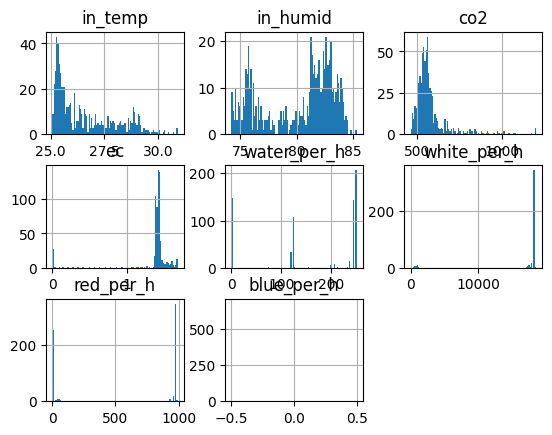

In [60]:
X_case_0.hist(bins=100)

array([[<AxesSubplot: title={'center': 'in_temp'}>,
        <AxesSubplot: title={'center': 'in_humid'}>,
        <AxesSubplot: title={'center': 'co2'}>],
       [<AxesSubplot: title={'center': 'ec'}>,
        <AxesSubplot: title={'center': 'water_per_h'}>,
        <AxesSubplot: title={'center': 'white_per_h'}>],
       [<AxesSubplot: title={'center': 'red_per_h'}>,
        <AxesSubplot: title={'center': 'blue_per_h'}>, <AxesSubplot: >]],
      dtype=object)

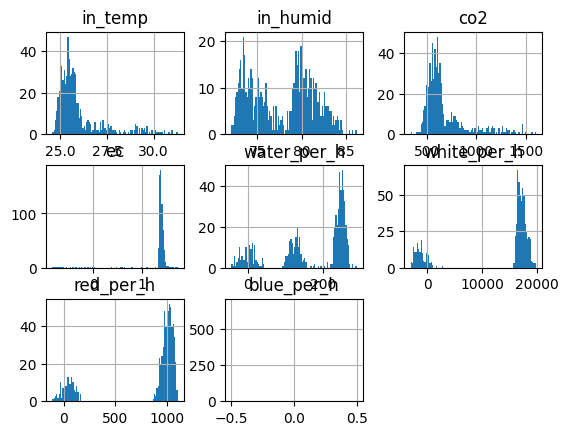

In [62]:
aug_samples.hist(bins=100)

In [22]:
# X_case_0['obs_time'].value_counts()

In [63]:
# check data shape
X_case_0.shape, aug_samples.shape

((672, 8), (672, 8))

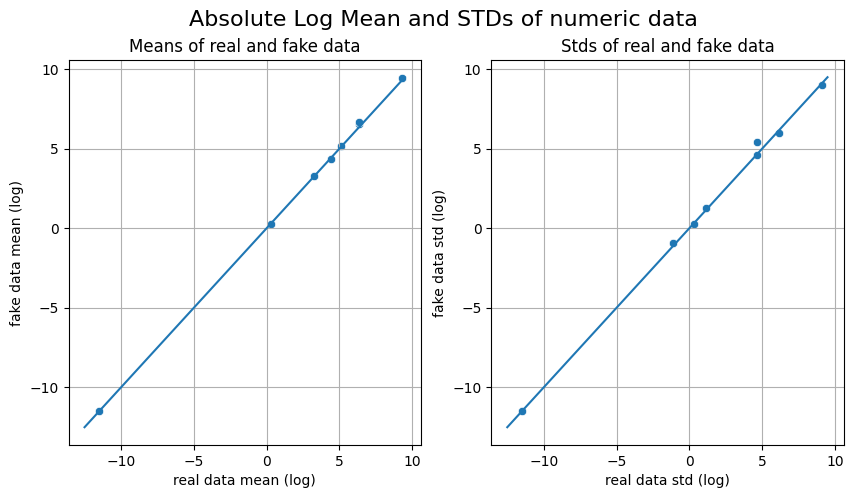

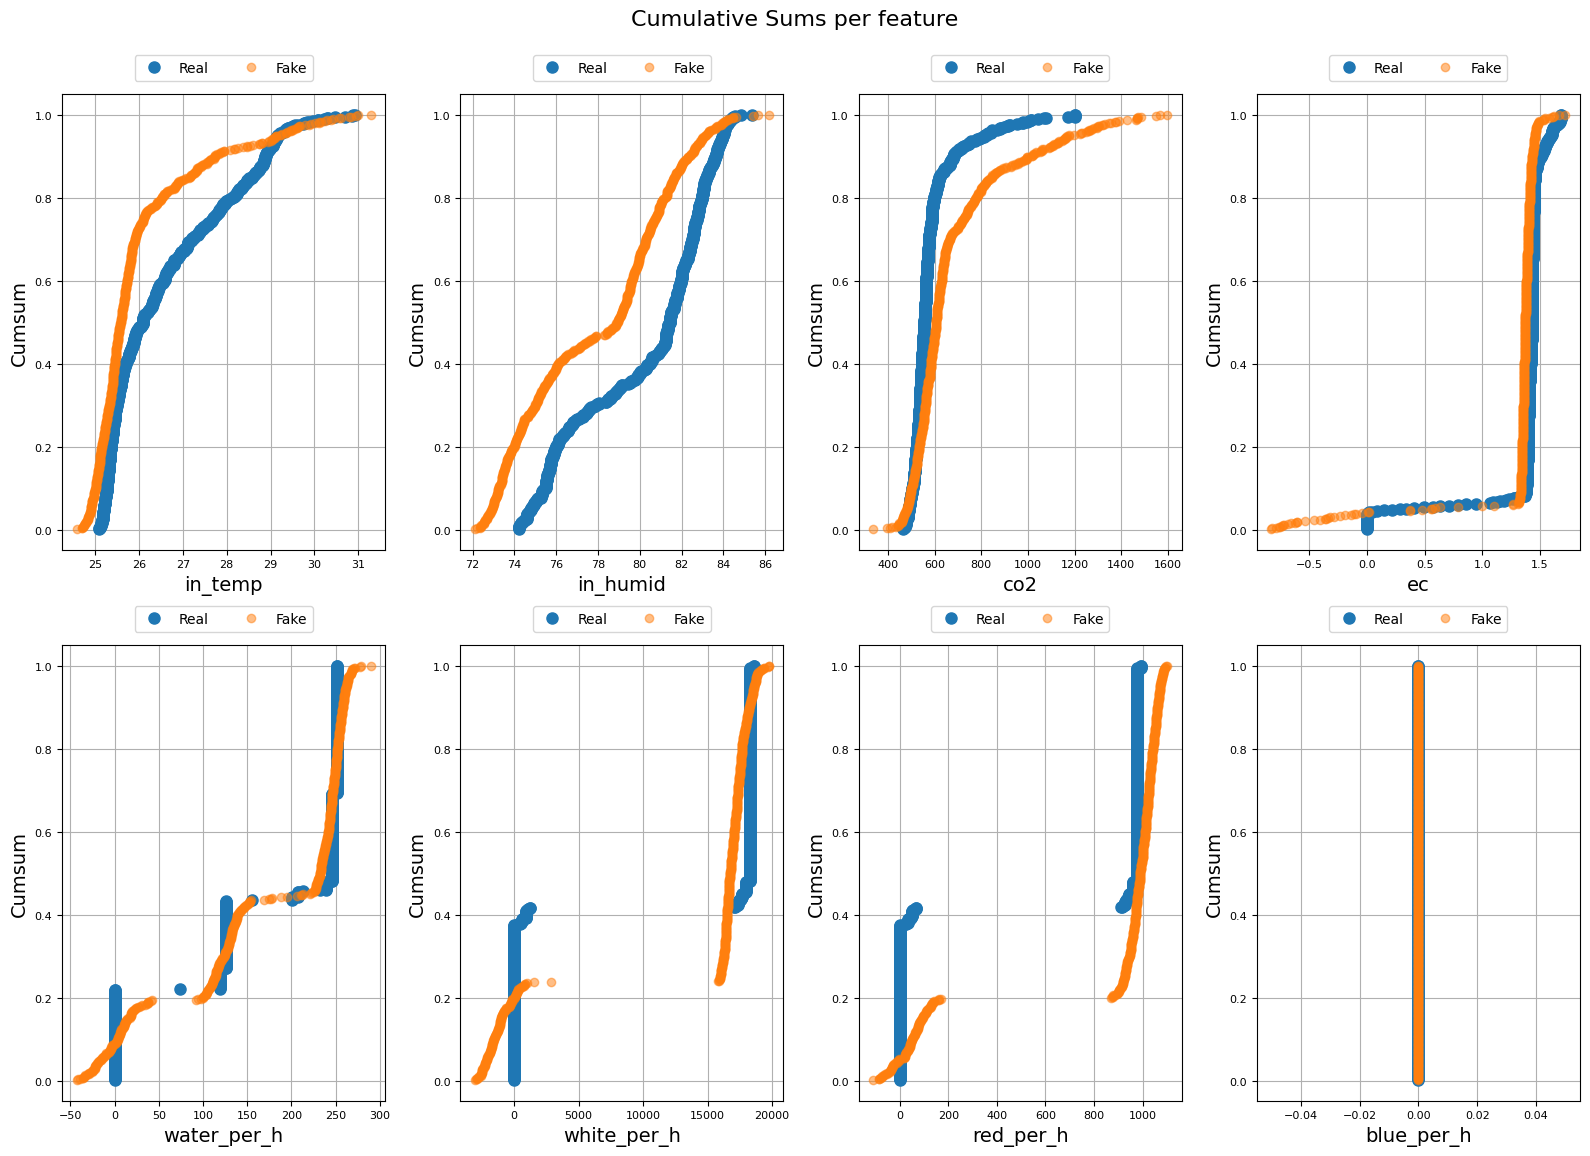

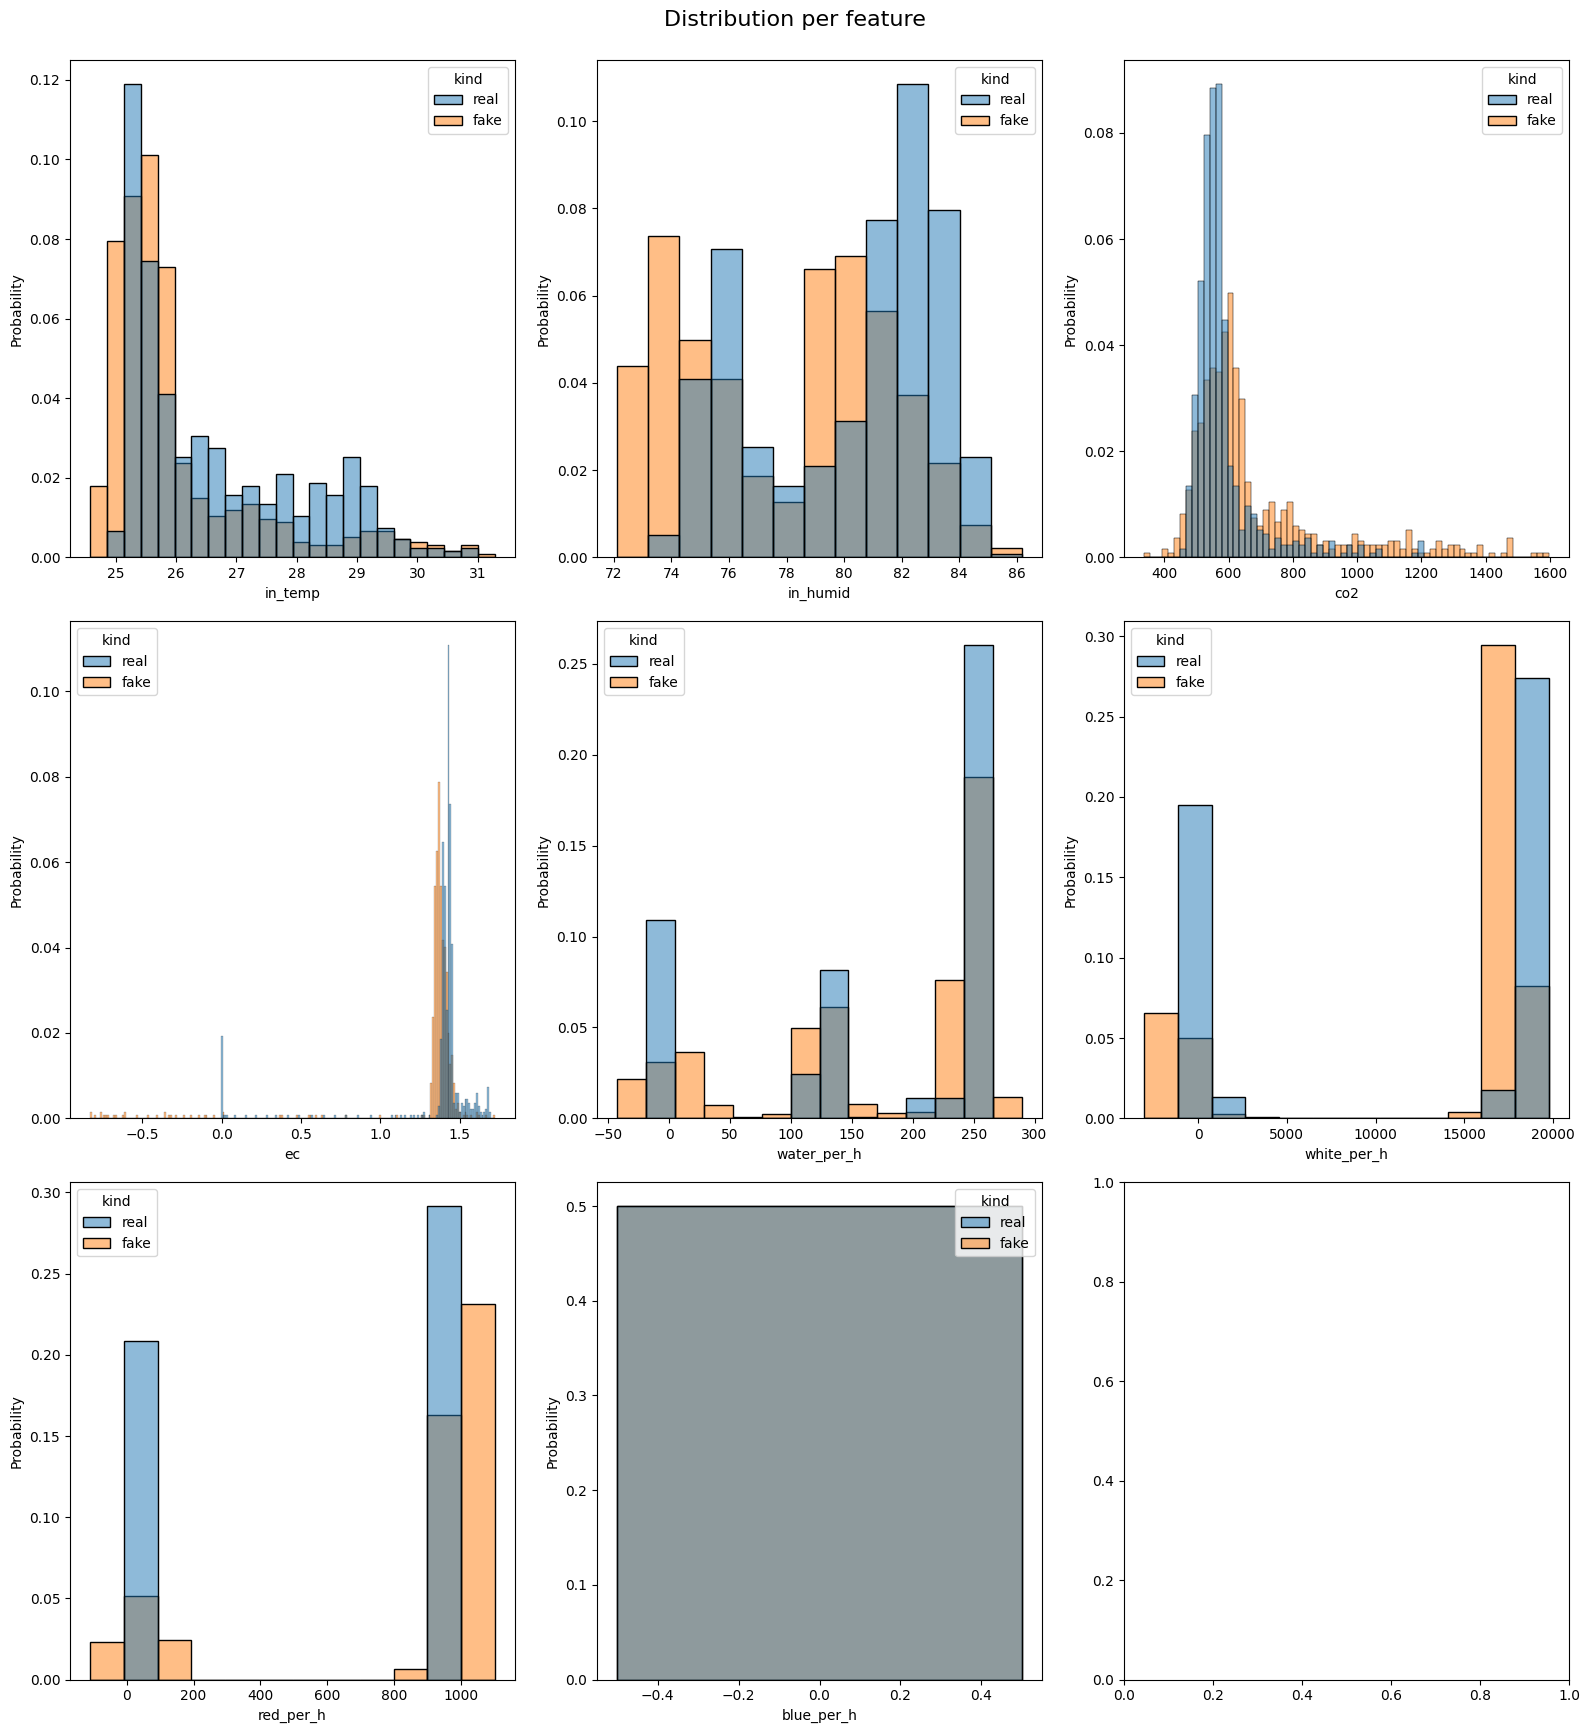

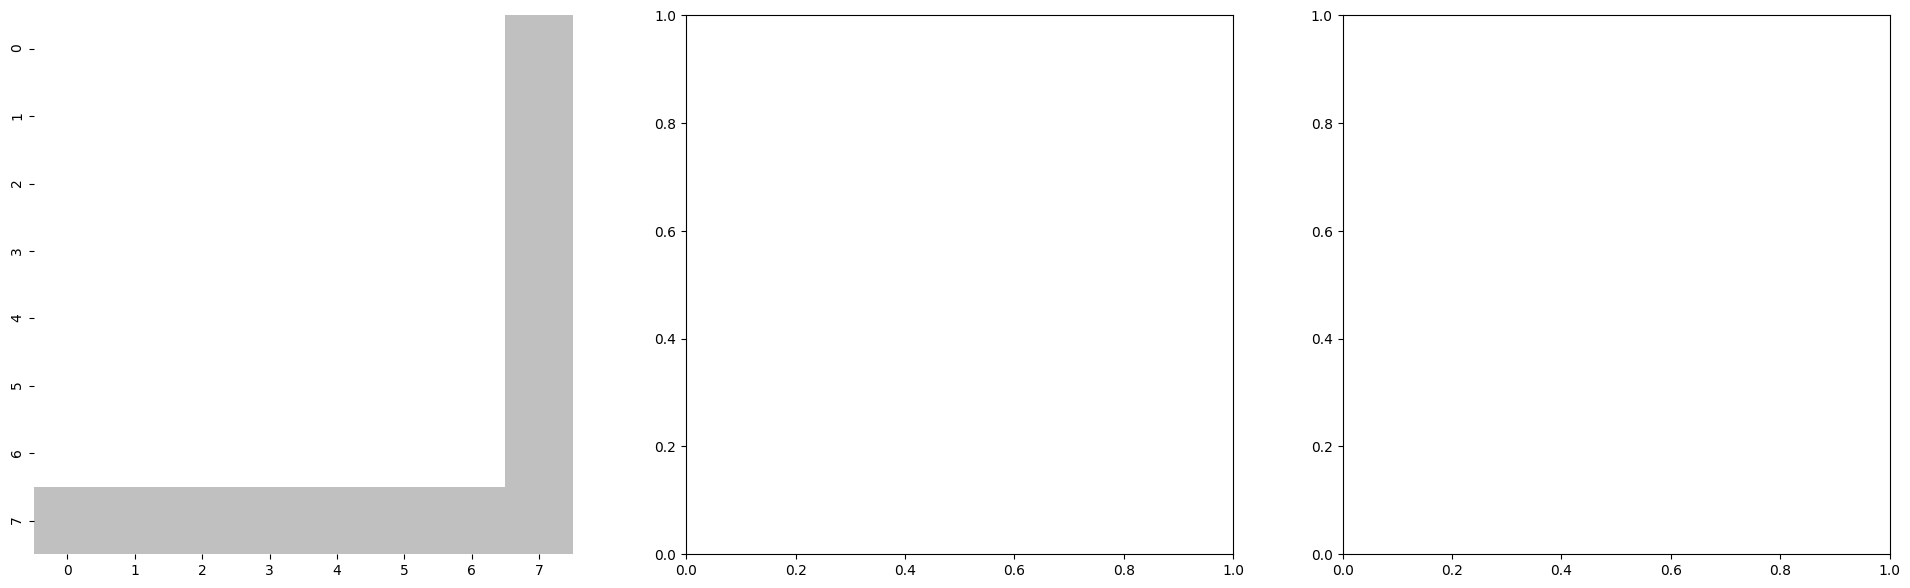

In [64]:
table_evaluator = TableEvaluator(X_case_0, aug_samples) #, cat_cols=discrete_cols)
try:
    table_evaluator.visual_evaluation()
except:
    pass